In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


### Ran this on colab, if you are running, please change the path for this file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to the zip file on the google drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/lfw.zip'

# Path for unzipped file
extracted_path = './lfw/'

# Making directory for extraction
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [ ]:
# List the contents of the unzipped folder
os.listdir(extracted_path)

['__MACOSX', 'lfw']

In [4]:
path = '/content/lfw/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


torch.Size([250, 250, 3])


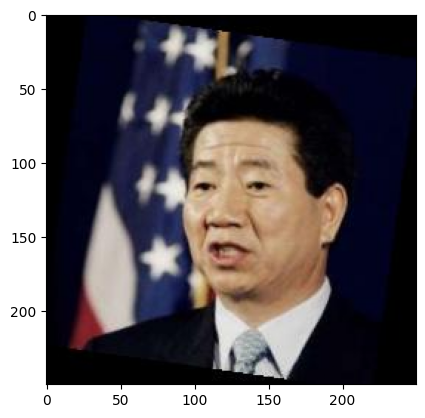

In [10]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [11]:
for x,y in dataloader:
    x = x[0]
    print(x.shape)
    break

torch.Size([3, 250, 250])


**3:** This dimension signifies the number of channels in the image tensor. For this RGB (Red, Green, Blue) image, this value of 3 indicates three channels representing the intensity of each color.

**250:** This denotes the height of the image tensor, indicating that the image has a height of 250 pixels.

**250:** This dimension represents the width of the image tensor, specifying that the image has a width of 250 pixels.


In [86]:
for x,y in dataloader:
    print(x.shape)
    break

torch.Size([32, 3, 250, 250])


In this one **32** represents the batch size

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

The below model is my **best model**, the shape of the encoded latent space is **32 x 32.** It has 3 layers and a total of **62555** parameters. **ReLU()** is the activation function except for the last layer where I have used **Sigmoid()**. Since I am compressing the image to **32 x 32** from **250 x 250**, I am getting good reconstruction of the image.

The comments on the side of the layer represents the shape of the tensor after each layer.

In [ ]:
import torch.nn.functional as F

class AE1(nn.Module):
    def __init__(self):
        super(AE1, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # (32, 16, 125, 125)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (32, 32, 63, 63)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (32, 64, 32, 32)
            nn.ReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # (32, 32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1), # (32, 16, 127, 127)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1), # (32, 8, 253, 253)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=1, padding=3), # (32, 3, 250, 250)
            nn.Sigmoid(),
        )


    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [16]:
for x,y in dataloader:
    image = x[0]
    print(image.shape)
    break

torch.Size([3, 250, 250])


In [ ]:
model1 = AE1()

encoder_output = model1.encoder(image.unsqueeze(0))
print("Encoder output shape:", encoder_output.shape)

decoder_output = model1.decoder(encoder_output)
print("Decoder output shape:", decoder_output.shape)

Encoder output shape: torch.Size([1, 64, 32, 32])
Decoder output shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 62555


In [ ]:
loss_function = nn.MSELoss()

The objective is to minimize the discrepancies at the individual pixel level. The Mean Squared Error (MSE) loss directly addresses variations in pixel values between the original and reconstructed images by measuring the averaged squared distances between them. Minimizing this loss, encourages the model to produce more accurate reconstructed image which matches the input image.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
import torch.optim as optim

num_epochs = 10
model1.to(device)
print(device)

# Setting the initial learning rate, declaring weight decay
learning_rate = 0.01

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = loss_function(outputs, inputs)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, total_loss / len(dataloader)))

print("Finished Training")


cuda:0
Epoch [1/10], Loss: 0.0022
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004
Finished Training


We could do a couple of things to reduce the loss if it is not decreasing, based on what the issue is, it could be one among the following:

1. **Improper learning rate:** If the learning rate is improper, then the loss starts plateauing. In that case, we can try changing the learning rate. We could also use a learning rate scheduler so that it will update the loss on its own after each epoch.

2. **Improper Optimizer:** Not all Optimizers will perform well on all models. Each of them have different internal working mechanisms, we should try to experiment with the different ones based on our requirements and choose the best one.

3. **Simple Model:** If the model is too simple and shallow for a complex task then it won't capture complex patters and the loss will stay constant. We should try adding more layers and increase the depth to better understand the input features.

4. **Improper dimensions /colour channels:** If the dimensions are wrong or the colour channels are too less or too many, it will yeild in improper output.

5. **Over Compression:** If the input is compressed too much during the encoder phase, then the decoder will have a hard time bringing it back up to the original dimension and the loss will plateau.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

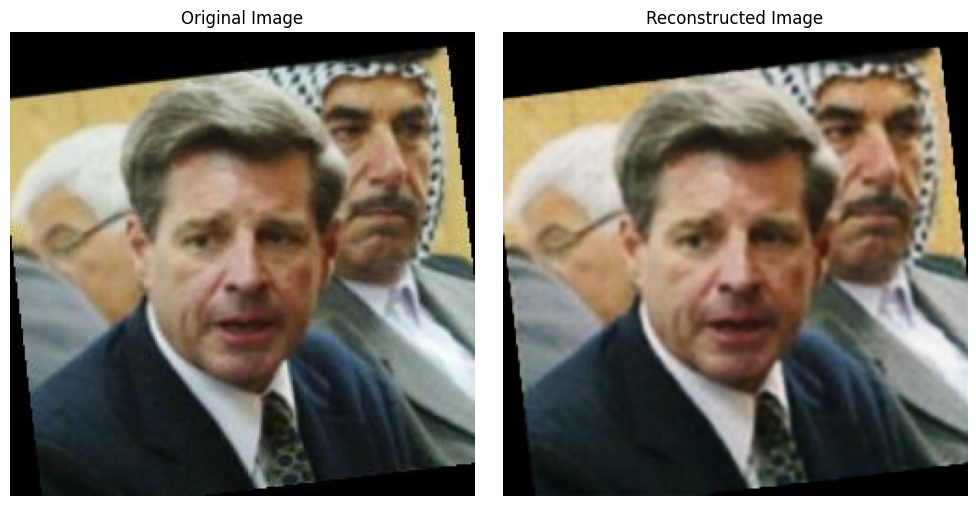

In [ ]:
import matplotlib.pyplot as plt
import random

model1.eval()

random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]
random_image = random_image.unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_image = model1(random_image)

random_image_np = random_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.cpu().squeeze(0).permute(1, 2, 0).numpy()

reconstructed_image_np = reconstructed_image_np.clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(random_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

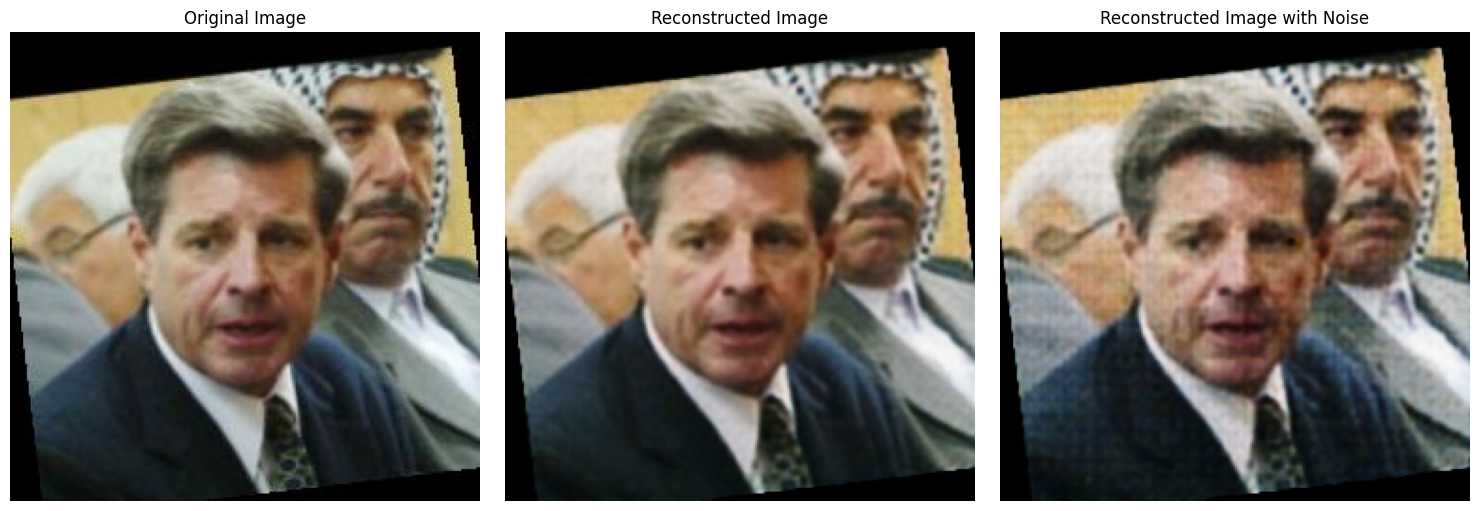

In [ ]:
with torch.no_grad():
    encoded_image = model1.encoder(random_image)

    # Setting mean and standard deviation for generating normally distributed noise
    mean = 0.1
    std_dev = 0.1
    noise = torch.normal(mean=mean, std=std_dev, size=encoded_image.shape).to(encoded_image.device)

    noisy_encoded_image = encoded_image + noise

    reconstructed_image_noisy = model1.decoder(noisy_encoded_image)

reconstructed_image_noisy_np = reconstructed_image_noisy.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_noisy_np = reconstructed_image_noisy_np.clip(0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(random_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_noisy_np)
axes[2].set_title('Reconstructed Image with Noise')
axes[2].axis('off')

plt.tight_layout()
plt.show()



When noise is introduced to the encoder's condensed representation, it hampers the model's ability to accurately reproduce the original image. The encoder is good at squeezing the input details into a small space. However, by altering this representation with noise post-training, it disrupts the meaningful patterns the encoder has captured, leading to distortions in the reconstructed output.







## Model 2

**Model 2** is an extension of main model 1. In the main model, the size of encoded image was **32 x 32**. Here I have added one more layer to reduce that to **16 x 16**, making the encoded image much smaller than the previous model also which increase the total parameters to **165083**.

In [ ]:
import torch.nn.functional as F

class AE2(nn.Module):
    def __init__(self):
        super(AE2, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=1, padding=3),
            nn.Sigmoid(),
        )


    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

In [ ]:
model2 = AE2()

encoder_output = model2.encoder(image.unsqueeze(0))
print("Encoder output shape:", encoder_output.shape)

decoder_output = model2.decoder(encoder_output)
print("Decoder output shape:", decoder_output.shape)

Encoder output shape: torch.Size([1, 64, 16, 16])
Decoder output shape: torch.Size([1, 3, 250, 250])


In [ ]:
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 165083


In [ ]:
loss_function = nn.MSELoss()

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 15
model2.to(device)
print(device)

# Setting the initial learning rate, declaring weight decay
learning_rate = 0.01
weight_decay = 1e-5

optimizer = optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_function(outputs, inputs)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, total_loss / len(dataloader)))

print("Finished Training")


cuda:0
Epoch [1/15], Loss: 0.0189
Epoch [2/15], Loss: 0.0082
Epoch [3/15], Loss: 0.0046
Epoch [4/15], Loss: 0.0030
Epoch [5/15], Loss: 0.0027
Epoch [6/15], Loss: 0.0039
Epoch [7/15], Loss: 0.0025
Epoch [8/15], Loss: 0.0035
Epoch [9/15], Loss: 0.0028
Epoch [10/15], Loss: 0.0024
Epoch [11/15], Loss: 0.0022
Epoch [12/15], Loss: 0.0021
Epoch [13/15], Loss: 0.0020
Epoch [14/15], Loss: 0.0020
Epoch [15/15], Loss: 0.0020
Finished Training


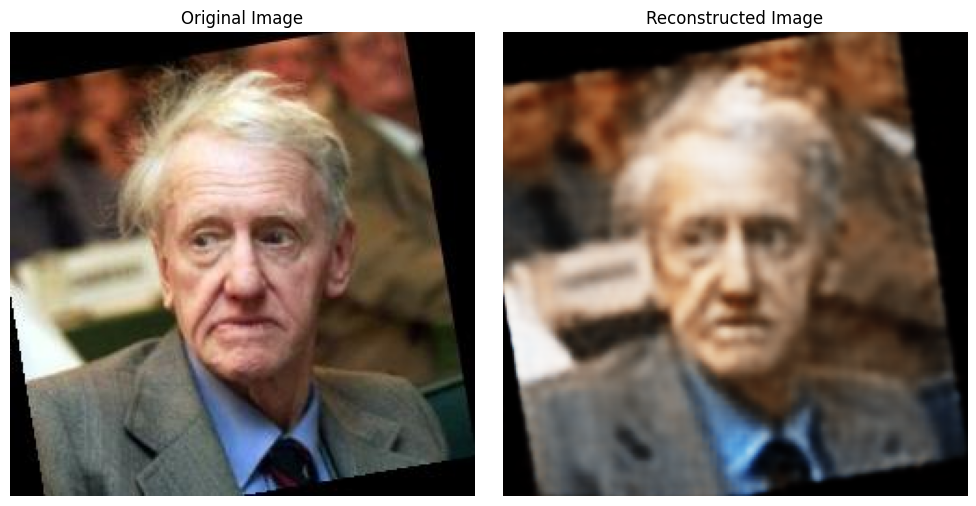

In [ ]:
import matplotlib.pyplot as plt
import random

model2.eval()

random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]
random_image = random_image.unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_image = model2(random_image)

random_image_np = random_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.cpu().squeeze(0).permute(1, 2, 0).numpy()

reconstructed_image_np = reconstructed_image_np.clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(random_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

As we see above, the reconstructed image is not as good as model 1 because, the image is compressed too much to **16 x 16** and it has lost some of the main features of the image and it is very difficult to reconstruct the image which closely represents the input image.

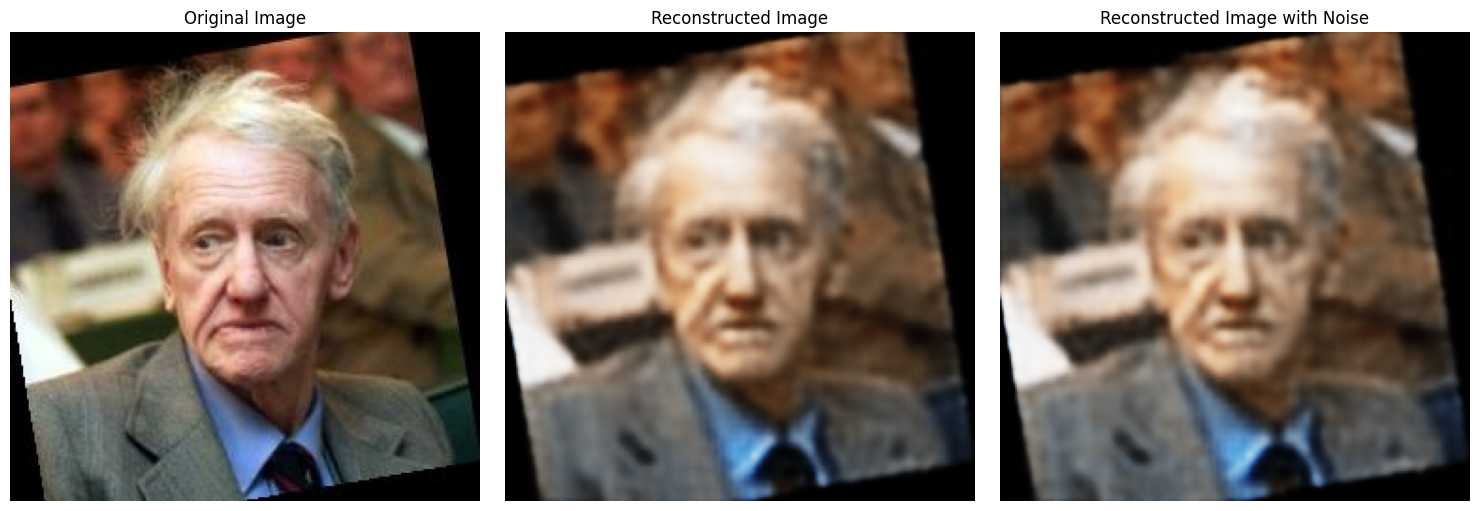

In [ ]:
with torch.no_grad():
    encoded_image = model2.encoder(random_image)

    # Setting mean and standard deviation for generating normally distributed noise
    mean = 0.1
    std_dev = 0.1
    noise = torch.normal(mean=mean, std=std_dev, size=encoded_image.shape).to(encoded_image.device)

    noisy_encoded_image = encoded_image + noise

    reconstructed_image_noisy = model2.decoder(noisy_encoded_image)

reconstructed_image_noisy_np = reconstructed_image_noisy.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_noisy_np = reconstructed_image_noisy_np.clip(0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(random_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_noisy_np)
axes[2].set_title('Reconstructed Image with Noise')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Model 3
**Model 3** is an extension of **Model 2**, the shape of encoded output here is **15 x 15**. But I have also added **MaxPoo2d** in **Encoder**, which helps in focusing on most essential features and discarding less relevant information.

**Decoder** contains **PixelShuffle** in this model which helps in **upscaling** the resolution of an image. But even after using all these the reconstruction is not as good as the main model due to over compression in the encoder.

In [77]:
import torch.nn as nn

class AE3(nn.Module):
    def __init__(self):
        super(AE3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.PixelShuffle(2),
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.PixelShuffle(2),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.PixelShuffle(2),
            nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.PixelShuffle(2),
            nn.Conv2d(8, 3, kernel_size=1, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

In [78]:
model3 = AE3()

encoder_output = model3.encoder(image.unsqueeze(0))
print("Encoder output shape:", encoder_output.shape)

decoder_output = model3.decoder(encoder_output)
print("Decoder output shape:", decoder_output.shape)

Encoder output shape: torch.Size([1, 128, 15, 15])
Decoder output shape: torch.Size([1, 3, 250, 250])


In [79]:
total_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 143259


In [80]:
loss_function = nn.MSELoss()

In [81]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 15
model3.to(device)
print(device)

# Setting the initial learning rate, declaring weight decay
learning_rate = 0.01
weight_decay = 1e-5

optimizer = optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = loss_function(outputs, inputs)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, total_loss / len(dataloader)))

print("Finished Training")


cuda:0
Epoch [1/15], Loss: 0.0202
Epoch [2/15], Loss: 0.0090
Epoch [3/15], Loss: 0.0091
Epoch [4/15], Loss: 0.0080
Epoch [5/15], Loss: 0.0090
Epoch [6/15], Loss: 0.0082
Epoch [7/15], Loss: 0.0078
Epoch [8/15], Loss: 0.0073
Epoch [9/15], Loss: 0.0071
Epoch [10/15], Loss: 0.0069
Epoch [11/15], Loss: 0.0068
Epoch [12/15], Loss: 0.0067
Epoch [13/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0065
Finished Training


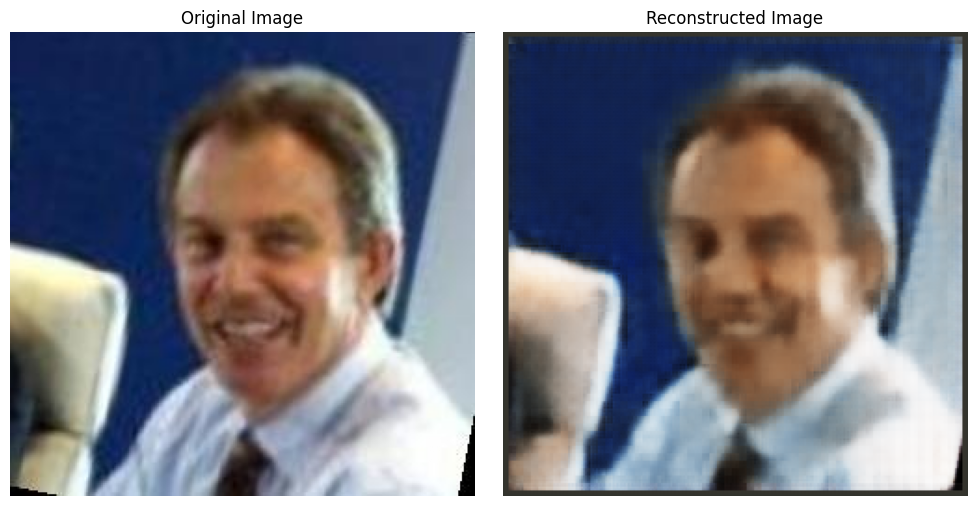

In [84]:
model3.eval()

# Choosing random image from the data loader
random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]
random_image = random_image.unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_image = model3(random_image)

random_image_np = random_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.cpu().squeeze(0).permute(1, 2, 0).numpy()

reconstructed_image_np = reconstructed_image_np.clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(random_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Even after using **MaxPool2d**, **Upscaling** etc. the reconstruction is **bad** compared to the main model due to **over-compression** of the image in the encoder.